In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR  = '/content/drive/MyDrive/Data/MVTecAD'  # 데이터셋 상위 경로
SAVE_NAME = f'best_skipgan.pt'

# =============================================================
# 0.  의존성 & 전역 설정
# =============================================================
import os, random, time
from glob   import glob
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import roc_auc_score
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

IMG_SIZE   = 256
BATCH_SIZE = 16
EPOCHS     = 100
LR_G, LR_D = 1e-4, 1e-4
BETAS = (0.5, 0.999)
lambda_GP = 0.0 #spectral norm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ device:', DEVICE)

# =============================================================
# 1.  데이터셋 & DataLoader
# =============================================================
class MVTecADMulti(Dataset):
    """
    지정한 카테고리만 스캔하도록 수정됨
      · phase='train' → bottle/train/good   (label=0)
      · phase='test'  → bottle/test/good      (label=0)
                        bottle/test/<defect>/*(label=1)
    """
    def __init__(self, root_dir:str, phase:str='train'):
        assert phase in ('train', 'test')
        self.phase = phase
        self.paths = []  # (img_path, label)

        # 'bottle' 카테고리 경로만 직접 지정
        cat_path = Path(root_dir) / 'bottle'

        if not cat_path.is_dir():
            # 'bottle' 폴더가 없을 경우 오류 발생
            raise FileNotFoundError(f"지정된 경로에 'bottle' 폴더가 없습니다: {cat_path}")

        if phase == 'train':
            # 훈련 데이터: 정상(good) 샘플만 로드
            self.paths += [(p, 0) for p in glob(str(cat_path / 'train' / 'good' / '*.png'))]
        else:  # 'test'
            # 테스트 데이터: 정상(good) 샘플 로드
            self.paths += [(p, 0) for p in glob(str(cat_path / 'test' / 'good' / '*.png'))]
            # 테스트 데이터: 비정상(defect) 샘플들 로드
            for defect in os.listdir(cat_path / 'test'):
                if defect == 'good':
                    continue
                defect_path = cat_path / 'test' / defect
                self.paths += [(p, 1) for p in glob(str(defect_path / '*.png'))]

        self.tf = T.Compose([
            T.ToPILImage(),
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.ToTensor(),
            T.Normalize([0.5] * 3, [0.5] * 3)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path, label = self.paths[idx]
        img = plt.imread(img_path)
        if img.ndim == 2:  # grayscale → 3-ch
            img = np.stack([img] * 3, -1)
        if img.max() <= 1:  # [0,1] → [0,255]
            img = (img * 255).astype(np.uint8)
        # ❗ [수정] 이미지 경로를 함께 반환
        return self.tf(img), label, img_path


def get_loaders_all(root_dir):
    train_ds = MVTecADMulti(root_dir, 'train')
    test_ds  = MVTecADMulti(root_dir, 'test')

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    # ❗ [수정] 테스트 시에는 데이터를 섞지 않도록 shuffle=False로 변경
    test_loader  = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

✅ device: cuda


In [ ]:
# =============================================================
# 2.  네트워크 정의 (Skip-GANomaly)
# =============================================================
class Generator(nn.Module):
    """
    Skip-GANomaly Generator:
    인코더-디코더 구조에 U-Net 스타일 스킵 연결 추가
    """
    def __init__(self, in_ch=3, latent_dim=100):
        super(Generator, self).__init__()

        # 인코더 (Encoder)
        self.e1 = nn.Conv2d(in_ch, 64, 4, 2, 1, bias=False)  # 128x128
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),  # 64x64
            nn.BatchNorm2d(128)
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),  # 32x32
            nn.BatchNorm2d(256)
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),  # 16x16
            nn.BatchNorm2d(512)
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 512, 4, 2, 1, bias=False)),  # 8x8
            nn.BatchNorm2d(512)
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 512, 4, 2, 1, bias=False)),  # 4x4
            nn.BatchNorm2d(512)
        )

        # 병목층 (Bottleneck)
        self.bottleneck = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, latent_dim, 4, 1, 0, bias=False)),  # 1x1
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # 디코더 (Decoder)
        self.d1 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(512 + 512, 512, 4, 2, 1, bias=False)),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.d2 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(512 + 512, 256, 4, 2, 1, bias=False)),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.d3 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(256 + 512, 128, 4, 2, 1, bias=False)),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.d4 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(128 + 256, 64, 4, 2, 1, bias=False)),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.d5 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(64 + 128, 32, 4, 2, 1, bias=False)),  # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.d6 = nn.Sequential(
            nn.ConvTranspose2d(32 + 64, 3, 4, 2, 1, bias=False),  # 256x256
            nn.Tanh()
        )

    def forward(self, x):
        # 인코더 부분
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)

        # 병목층
        b = self.bottleneck(e6)

        # 디코더 부분 (스킵 연결 추가)
        d1 = self.d1(torch.cat([b, e6], 1))
        d2 = self.d2(torch.cat([d1, e5], 1))
        d3 = self.d3(torch.cat([d2, e4], 1))
        d4 = self.d4(torch.cat([d3, e3], 1))
        d5 = self.d5(torch.cat([d4, e2], 1))
        d6 = self.d6(torch.cat([d5, e1], 1))

        return d6


class Discriminator(nn.Module):
    """
    판별자: 실제 이미지와 생성된 이미지를 구분하고
    중간 특징 맵을 반환하여 Feature Matching Loss에 사용
    """
    def __init__(self, in_ch=3):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # 입력: 3 x 256 x 256
            spectral_norm(nn.Conv2d(in_ch, 64, 4, 2, 1, bias=False)),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 특징 맵 추출용 레이어
        self.features = nn.Sequential(
            spectral_norm(nn.Conv2d(512, 512, 4, 2, 1, bias=False)),  # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 최종 판별자 출력 (패치 GAN 스타일)
        self.output = nn.Sequential(
            spectral_norm(nn.Conv2d(512, 1, 4, 1, 1, bias=False))  # 7x7
        )

    def forward(self, x, return_feat=False):
        x = self.main(x)
        feat = self.features(x)
        out = self.output(feat)

        if return_feat:
            return out, feat.view(feat.size(0), -1)  # 배치 내 각 샘플의 특징을 평탄화
        else:
            return out

In [ ]:
# =============================================================
# 3.  학습 루프 & 평가 함수
# =============================================================
L_adv, L_rec, L_fm = nn.BCEWithLogitsLoss(), nn.L1Loss(), nn.L1Loss()

def gradient_penalty(D, real, fake):
    a_weights = torch.rand(real.size(0),1,1,1, device=real.device)
    inter = (a_weights*real + (1-a_weights)*fake).requires_grad_(True)
    score = D(inter)
    grad  = autograd.grad(outputs=score, inputs=inter,
                          grad_outputs=torch.ones_like(score),
                          create_graph=True, retain_graph=True)[0]
    gp = ((grad.view(grad.size(0), -1).norm(2, dim=1) - 1)**2).mean()
    return gp

def train_epoch(G,D,loader,optG,optD,lambda_rec=50,lambda_fm=10):
    G.train(); D.train(); g_tot=d_tot=0
    for imgs, _, _ in tqdm(loader, leave=False):
        imgs = imgs.to(DEVICE)

        # --- D (maximize real-fake gap) ---
        optD.zero_grad()
        fake = G(imgs).detach()
        d_real = D(imgs)
        d_fake = D(fake)
        gp = gradient_penalty(D, imgs, fake)
        d_loss = -(d_real.mean() - d_fake.mean()) + lambda_GP*gp
        d_loss.backward(); optD.step()

        # --- G (fool D + recon + feature-match) ---
        optG.zero_grad()
        fake = G(imgs)
        g_adv = -D(fake).mean()                     # WGAN generator loss
        _, feat_f = D(fake, True)
        _, feat_r = D(imgs, True)
        g_rec = L_rec(fake, imgs)
        g_fm  = L_fm(feat_f, feat_r.detach())
        g_loss = g_adv + lambda_rec*g_rec + lambda_fm*g_fm
        g_loss.backward(); optG.step()

        g_tot += g_loss.item();  d_tot += d_loss.item()
    n=len(loader); return g_tot/n, d_tot/n

@torch.inference_mode()
def get_scores(G, loader):
    G.eval(); scores=[]; labels=[]
    for imgs, lbl, _ in loader:
        imgs = imgs.to(DEVICE)
        err  = torch.mean((G(imgs) - imgs).abs(), dim=[1,2,3])
        scores += err.cpu().tolist(); labels += lbl
    return np.array(scores), np.array(labels)

def fit_all(root_dir, save_path_g, save_path_d):
    """
    모델을 학습하고, 가장 성능이 좋았던 시점의
    Generator(G)와 Discriminator(D) 모델 객체를 반환합니다.
    """
    tl, vl = get_loaders_all(root_dir)
    G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)
    optG = torch.optim.Adam(G.parameters(), LR_G, betas=BETAS)
    optD = torch.optim.Adam(D.parameters(), LR_D, betas=BETAS)

    best_auc = 0
    best_G_state = None
    best_D_state = None # [추가] 최고 성능 D의 가중치를 저장할 변수

    for ep in range(1, EPOCHS+1):
        g, d = train_epoch(G, D, tl, optG, optD)
        s, l = get_scores(G, vl)
        auc = roc_auc_score(l, s)

        if auc > best_auc:
            best_auc = auc
            # [수정] G와 D의 가중치를 함께 저장
            best_G_state = copy.deepcopy(G.state_dict())
            best_D_state = copy.deepcopy(D.state_dict())
            torch.save(best_G_state, save_path_g)
            torch.save(best_D_state, save_path_d)

        print(f'[Ep {ep:03d}] G:{g:.3f}  D:{d:.3f}  AUC:{auc:.4f} (best {best_auc:.4f})')

    print(f'\nDone! best AUC: {best_auc:.4f}')

    # [수정] G와 D 모두에 최고 성능 가중치를 로드
    if best_G_state and best_D_state:
        G.load_state_dict(best_G_state)
        D.load_state_dict(best_D_state)

    # [수정] G와 D 모델 객체를 모두 반환
    return G, D

In [ ]:
# =============================================================
# 4.  학습 실행
# =============================================================

# G와 D의 저장 경로를 각각 정의합니다.
G_SAVE_NAME = 'best_skipgan_all.pt'
D_SAVE_NAME = 'best_skipgan_all_D.pt'

# 2개의 저장 경로를 모두 인자로 전달합니다.
best_G, best_D = fit_all(ROOT_DIR, G_SAVE_NAME, D_SAVE_NAME)

  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 001] G:35.477  D:-11.648  AUC:0.2627 (best 0.2627)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 002] G:31.466  D:-22.169  AUC:0.3937 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 003] G:5.074  D:-9.363  AUC:0.3738 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 004] G:-5.763  D:-0.308  AUC:0.3310 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 005] G:-4.497  D:-0.416  AUC:0.2937 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 006] G:-3.283  D:-0.513  AUC:0.2738 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 007] G:-3.088  D:-0.478  AUC:0.2690 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 008] G:-2.804  D:-0.514  AUC:0.2500 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 009] G:-1.363  D:-0.661  AUC:0.2611 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 010] G:-0.606  D:-0.820  AUC:0.2921 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 011] G:0.714  D:-1.022  AUC:0.2397 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 012] G:1.055  D:-1.096  AUC:0.1897 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 013] G:0.983  D:-1.223  AUC:0.2421 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 014] G:1.880  D:-1.430  AUC:0.2770 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 015] G:1.575  D:-1.478  AUC:0.3698 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 016] G:2.489  D:-1.487  AUC:0.2333 (best 0.3937)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 017] G:2.846  D:-1.602  AUC:0.4103 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 018] G:2.695  D:-1.738  AUC:0.2754 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 019] G:3.031  D:-1.677  AUC:0.3532 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 020] G:4.080  D:-2.111  AUC:0.2651 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 021] G:2.333  D:-1.784  AUC:0.3635 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 022] G:3.182  D:-1.894  AUC:0.3683 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 023] G:4.264  D:-2.106  AUC:0.3373 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 024] G:4.145  D:-2.435  AUC:0.1675 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 025] G:5.286  D:-3.048  AUC:0.2635 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 026] G:6.167  D:-3.122  AUC:0.4048 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 027] G:5.106  D:-3.150  AUC:0.2738 (best 0.4103)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 028] G:4.939  D:-3.298  AUC:0.4698 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 029] G:4.903  D:-3.317  AUC:0.3167 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 030] G:5.057  D:-2.962  AUC:0.4310 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 031] G:-0.682  D:-2.508  AUC:0.3651 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 032] G:-7.766  D:-0.427  AUC:0.3373 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 033] G:0.923  D:-1.863  AUC:0.2103 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 034] G:5.584  D:-3.558  AUC:0.3905 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 035] G:5.114  D:-3.433  AUC:0.3825 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 036] G:6.342  D:-4.901  AUC:0.3381 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 037] G:-0.768  D:-1.321  AUC:0.2730 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 038] G:5.652  D:-3.676  AUC:0.3651 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 039] G:9.659  D:-5.003  AUC:0.3635 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 040] G:5.330  D:-4.218  AUC:0.3278 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 041] G:5.383  D:-4.236  AUC:0.3254 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 042] G:8.113  D:-4.542  AUC:0.3937 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 043] G:4.081  D:-3.675  AUC:0.3325 (best 0.4698)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 044] G:7.380  D:-5.051  AUC:0.5238 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 045] G:9.161  D:-5.815  AUC:0.4556 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 046] G:8.262  D:-5.642  AUC:0.3008 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 047] G:7.741  D:-5.808  AUC:0.5151 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 048] G:8.435  D:-5.006  AUC:0.3889 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 049] G:7.860  D:-6.142  AUC:0.4476 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 050] G:8.467  D:-5.944  AUC:0.3079 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 051] G:7.063  D:-5.140  AUC:0.4159 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 052] G:5.355  D:-6.464  AUC:0.3833 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 053] G:8.565  D:-5.236  AUC:0.3817 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 054] G:8.323  D:-6.698  AUC:0.4000 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 055] G:10.480  D:-7.769  AUC:0.3587 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 056] G:10.429  D:-7.772  AUC:0.3706 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 057] G:9.131  D:-7.167  AUC:0.4310 (best 0.5238)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 058] G:7.753  D:-6.502  AUC:0.5429 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 059] G:12.486  D:-8.858  AUC:0.3476 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 060] G:13.767  D:-9.740  AUC:0.3460 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 061] G:12.517  D:-8.079  AUC:0.4333 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 062] G:10.646  D:-8.136  AUC:0.4516 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 063] G:9.265  D:-7.887  AUC:0.3667 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 064] G:5.166  D:-5.581  AUC:0.4857 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 065] G:8.554  D:-6.946  AUC:0.2802 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 066] G:12.115  D:-9.789  AUC:0.3056 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 067] G:12.369  D:-9.567  AUC:0.3921 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 068] G:13.205  D:-8.055  AUC:0.4071 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 069] G:7.290  D:-7.360  AUC:0.4119 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 070] G:13.995  D:-10.665  AUC:0.4151 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 071] G:3.631  D:-5.042  AUC:0.3675 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 072] G:4.003  D:-6.106  AUC:0.3873 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 073] G:8.609  D:-6.803  AUC:0.4976 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 074] G:13.655  D:-10.057  AUC:0.4302 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 075] G:9.929  D:-8.063  AUC:0.4921 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 076] G:15.929  D:-10.126  AUC:0.4706 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 077] G:14.076  D:-12.265  AUC:0.4722 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 078] G:12.417  D:-10.383  AUC:0.4548 (best 0.5429)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 079] G:7.849  D:-6.510  AUC:0.5532 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 080] G:13.859  D:-13.110  AUC:0.4103 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 081] G:5.887  D:-6.684  AUC:0.4659 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 082] G:18.392  D:-14.150  AUC:0.5262 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 083] G:12.276  D:-10.616  AUC:0.4270 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 084] G:14.288  D:-11.474  AUC:0.4651 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 085] G:16.733  D:-11.998  AUC:0.3952 (best 0.5532)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 086] G:22.683  D:-25.334  AUC:0.6944 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 087] G:32.133  D:-41.038  AUC:0.4921 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 088] G:13.236  D:-13.873  AUC:0.3754 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 089] G:6.919  D:-6.400  AUC:0.5103 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 090] G:24.119  D:-22.621  AUC:0.4579 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 091] G:24.042  D:-29.444  AUC:0.5167 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 092] G:4.059  D:-2.356  AUC:0.3627 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 093] G:16.169  D:-10.797  AUC:0.4024 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 094] G:17.887  D:-14.079  AUC:0.4603 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 095] G:22.375  D:-19.342  AUC:0.3262 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 096] G:25.538  D:-25.891  AUC:0.5937 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 097] G:28.266  D:-37.147  AUC:0.5992 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 098] G:34.620  D:-44.051  AUC:0.5079 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 099] G:35.548  D:-45.958  AUC:0.4230 (best 0.6944)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 100] G:30.908  D:-42.669  AUC:0.6508 (best 0.6944)

Done! best AUC: 0.6944


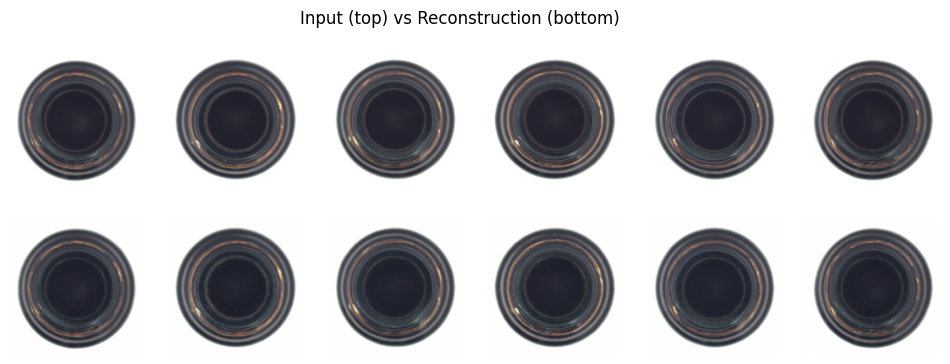

✔ 정상(good)   : 20
✔ 이상(defect) : 63


In [ ]:
# =============================================================
# 5.  재구성 시각화 (학습 후)
# =============================================================
SAVE_NAME = '/content/best_skipgan_all.pt'

@torch.inference_mode()
def show_recon(G, loader, n=6):
    G.eval()
    imgs, _, _ = next(iter(loader))
    imgs = imgs[:n].to(DEVICE)

    recon = G(imgs)
    imgs, recon = imgs.cpu()*0.5+0.5, recon.cpu()*0.5+0.5
    plt.figure(figsize=(n*2,4))
    for i in range(n):
        plt.subplot(2,n,i+1);     plt.imshow(imgs[i].permute(1,2,0));   plt.axis('off')
        plt.subplot(2,n,n+i+1);   plt.imshow(recon[i].permute(1,2,0));  plt.axis('off')
    plt.suptitle('Input (top) vs Reconstruction (bottom)'); plt.show()

# 💡 사용 예: 파일 로드 과정 없이, 위에서 반환받은 `best_G_model`을 즉시 사용
_, test_loader = get_loaders_all(ROOT_DIR)
show_recon(best_G, test_loader)

# 전체 데이터셋에 대해 정상/이상 개수 확인
num_norm = sum(1 for _, y, _ in test_loader.dataset if y == 0)
num_anom = sum(1 for _, y, _ in test_loader.dataset if y == 1)
print(f"✔ 정상(good)   : {num_norm:,}")
print(f"✔ 이상(defect) : {num_anom:,}")

In [ ]:
# 전체 데이터셋에 대해 정상/이상 개수 확인
num_norm = sum(1 for path, label in test_loader.dataset.paths if label == 0)
num_anom = sum(1 for path, label in test_loader.dataset.paths if label == 1)
print(f"✔ 정상(good)   : {num_norm:,}")
print(f"✔ 이상(defect) : {num_anom:,}")

✔ 정상(good)   : 20
✔ 이상(defect) : 63


Testing:   0%|          | 0/6 [00:00<?, ?it/s]

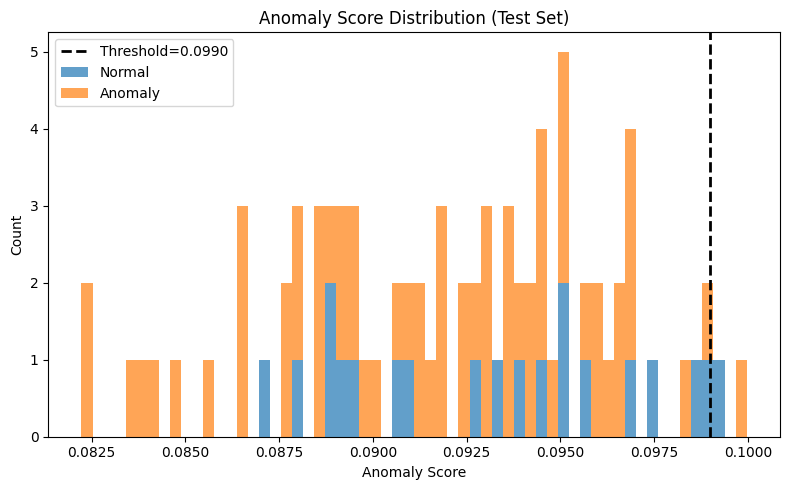

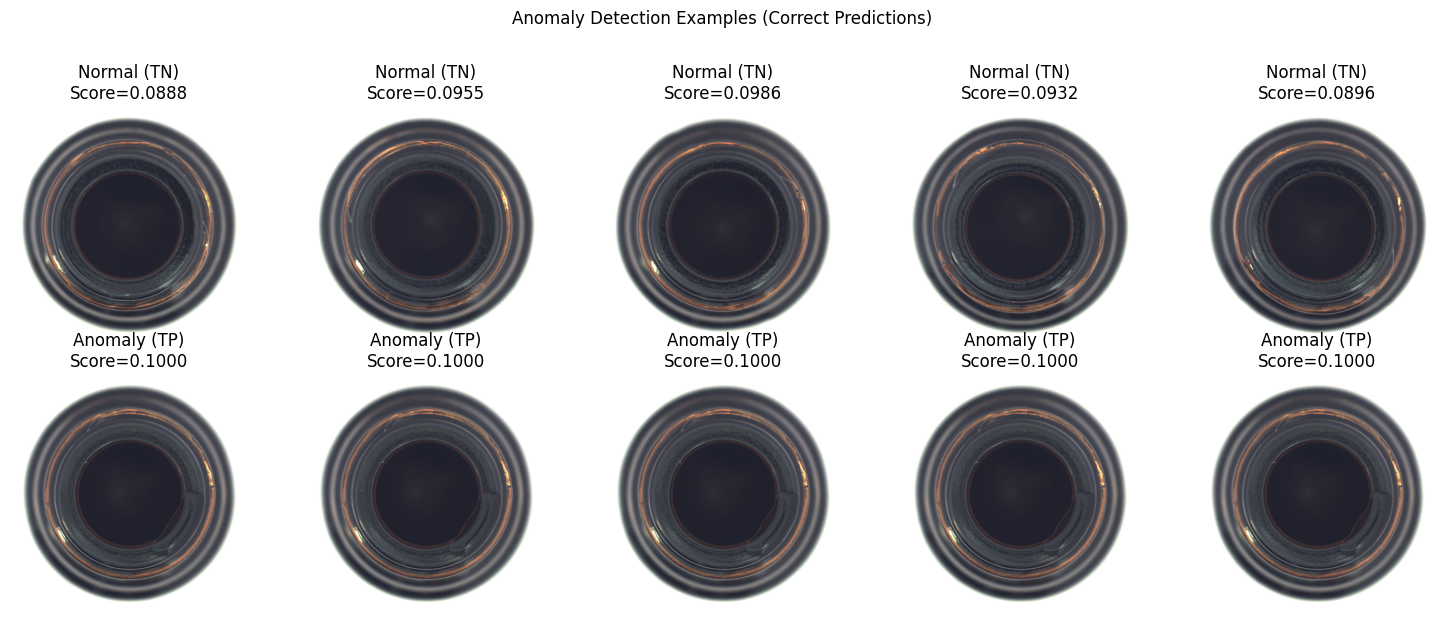

In [ ]:
# =============================================================
# 6.  테스트 & 시각화
# =============================================================
import torch.nn.functional as F

# ❗ [수정] 파일 로드 블록 전체를 삭제하고,
# 이전 단계에서 반환받은 모델 객체를 즉시 사용합니다.
best_G.eval()
best_D.eval()

# Anomaly Score 계산을 위한 가중치 (lambda)
LAMBDA_SCORE = 0.1

# ② 테스트 데이터셋 전체에 대해 Anomaly Score 계산
scores, labels, paths = [], [], []
with torch.no_grad():
    # test_loader는 미리 로드되어 있어야 합니다.
    _, test_loader = get_loaders_all(ROOT_DIR)

    for imgs, lbls, batch_paths in tqdm(test_loader, 'Testing'):
        imgs_gpu = imgs.to(DEVICE)

        # 1. 재구성 이미지 생성 (best_G 사용)
        recons = best_G(imgs_gpu)

        # 2. 재구성 오차 (L_con) 계산: |x - G(x)|
        err_rec = torch.mean(torch.abs(imgs_gpu - recons), dim=[1,2,3])

        # 3. 판별자 특징 추출 (best_D 사용)
        _, feat_real = best_D(imgs_gpu, return_feat=True)
        _, feat_fake = best_D(recons, return_feat=True)

        # 4. 특징 공간 오차 (L_enc) 계산: |f_D(x) - f_D(G(x))|
        err_enc = torch.mean(torch.abs(feat_real - feat_fake), dim=1)

        # 5. 최종 이상치 점수 계산
        batch_scores = (1 - LAMBDA_SCORE) * err_rec + LAMBDA_SCORE * err_enc

        scores.append(batch_scores.cpu().numpy())
        labels.append(lbls.numpy())
        paths += batch_paths

scores = np.concatenate(scores)
labels = np.concatenate(labels)


# ③ 결과를 바탕으로 시각화 (이하 로직은 동일)
# 정상 데이터의 점수 분포에서 95% 지점을 임계값으로 설정
THRESH = np.percentile(scores[labels == 0], 95)

# ---------- (1) 점수 분포 시각화 ----------
hist_n, edges = np.histogram(scores[labels == 0], bins=60, range=(scores.min(), scores.max()))
hist_a, _     = np.histogram(scores[labels == 1], bins=edges)
centers       = (edges[:-1] + edges[1:]) / 2
bar_width     = centers[1] - centers[0]

plt.figure(figsize=(8, 5))
plt.bar(centers, hist_n, width=bar_width, label='Normal',  alpha=.7)
plt.bar(centers, hist_a, width=bar_width, label='Anomaly', alpha=.7, bottom=hist_n)
plt.axvline(THRESH, ls='--', lw=2, color='k', label=f'Threshold={THRESH:.4f}')
plt.xlabel('Anomaly Score'); plt.ylabel('Count')
plt.title ('Anomaly Score Distribution (Test Set)'); plt.legend()
plt.tight_layout(); plt.show()


# ---------- (2) 정상·이상 판별 예시 시각화 ----------
def pick_idxs(labels, scores, thresh, n_each=5):
    # 정상으로 판별된 정상 샘플 (True Negative)
    idx_norm = np.where((labels == 0) & (scores < thresh))[0]
    # 이상으로 판별된 이상 샘플 (True Positive)
    idx_anom = np.where((labels == 1) & (scores > thresh))[0]

    # 각 그룹에서 n_each개씩 랜덤으로 선택
    # 샘플 수가 부족할 경우를 대비해 replace=True 설정
    sel_norm = np.random.choice(idx_norm, n_each, replace=len(idx_norm) < n_each)
    sel_anom = np.random.choice(idx_anom, n_each, replace=len(idx_anom) < n_each)

    return np.concatenate([sel_norm, sel_anom])

# 시각화할 샘플 인덱스 선택
sel_indices = pick_idxs(labels, scores, THRESH, 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6.5))
axes = axes.flatten()
for i, idx in enumerate(sel_indices):
    img = plt.imread(paths[idx])[..., :3]
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')

    # 앞 5개는 Normal, 뒤 5개는 Anomaly
    label_str = 'Normal (TN)' if i < 5 else 'Anomaly (TP)'
    ax.set_title(f"{label_str}\nScore={scores[idx]:.4f}")

plt.suptitle('Anomaly Detection Examples (Correct Predictions)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()